# PyTorch and CIFAR10 data analysis

I trained a custom ResNet9 model to recognize images from the CIFAR10 dataset with PyTorch.

David Page designed this model and got fantastic results for the [Stanford DAWNBench competition](https://dawn.cs.stanford.edu/benchmark/index.html). Here is a [blog post](https://myrtle.ai/learn/how-to-train-your-resnet/) that talks about the model and here is the [source code](https://github.com/davidcpage/cifar10-fast/tree/d31ad8d393dd75147b65f261dbf78670a97e48a8).

Using pyJoules, I logged the energy consumed in every epoch. This notebook will analyze 50 runs, each consisting of 24 epochs.

The experiments were run in the Chifflot 8 computer using a single NVIDIA V100 GPU.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme(style='white', palette='pastel')

In [3]:
DATA_DIRNAME = 'csv'

MODEL_INDEX = 0
EXPERIMENT_INDEX = 0
RUN_INDEX = None  # If None, all runs will be loaded

In [4]:
model_dirnames_all = sorted(
    [file.name for file in os.scandir(DATA_DIRNAME)
     if file.is_dir() and not file.name.startswith('.')])
model_dirname = model_dirnames_all[MODEL_INDEX]

print(f'Selected model\n- {model_dirname}\n')
print(f'Models\n- {f"{chr(10)}- ".join(model_dirnames_all)}')

Selected model
- fast

Models
- fast
- fast-mnist
- torchskeleton-defworker
- torchskeleton-noworker


In [5]:
experiment_dirnames_all = sorted(
    [file.name for file
     in os.scandir(os.path.join(DATA_DIRNAME, model_dirname))
     if file.is_dir() and not file.name.startswith('.')])
experiment_dirname = experiment_dirnames_all[EXPERIMENT_INDEX]

print(f'Selected experiment\n- {experiment_dirname}\n')
print(f'Experiments\n- {f"{chr(10)}- ".join(experiment_dirnames_all)}')

Selected experiment
- 2021-10-14-09-16-15-gpu

Experiments
- 2021-10-14-09-16-15-gpu
- 2021-10-14-12-30-14-gpu
- 2021-10-18-15-25-46-gpu
- 2021-10-19-11-31-50-nogpu
- 2021-10-21-15-02-56-gpu-cpu1
- 2021-10-22-10-10-55-gpu-core1-nohyper
- 2021-10-22-12-07-40-gpu-core1-hyper
- 2021-10-25-14-59-44-gpu-core1,3,5,7-nohyper


In [6]:
run_filenames_all = sorted(
    [file.name for file
     in os.scandir(os.path.join(
         DATA_DIRNAME,
         model_dirname,
         experiment_dirname))
     if file.is_file() and not file.name.startswith('.')])

if RUN_INDEX is None:
    run_filenames = run_filenames_all
    print(f'Selected runs\n- All\n')
else:
    run_filenames = [run_filenames_all[RUN_INDEX]]
    print(f'Selected run\n- {run_filenames[0]}\n')

if len(run_filenames) > 8:
    print('Runs\n- ', end='')
    print('\n- '.join(run_filenames[:4]))
    print('.\n.\n.\n- ', end='')
    print('\n- '.join(run_filenames[-4:]))
else:
    print(f'Runs\n- {f"{chr(10)}- ".join(run_filenames)}')

Selected runs
- All

Runs
- run-00.csv
- run-01.csv
- run-02.csv
- run-03.csv
.
.
.
- run-46.csv
- run-47.csv
- run-48.csv
- run-49.csv


In [7]:
df = pd.concat(
    [pd.read_csv(
        os.path.join(
            DATA_DIRNAME,
            model_dirname,
            experiment_dirname,
            run_filename))
     for run_filename in run_filenames])

In [8]:
# Remove first epoch as initialization makes it take longer
df = df.iloc[1:]

In [9]:
df = df.reset_index(drop=True)

## First columns of the dataframe

The first epoch is removed as initialization causes it to take considerably longer.

In [10]:
df.head()

,epoch,duration,train acc,valid acc,package_0 energy,package_1 energy,dram_0 energy,dram_1 energy,nvidia_gpu_0 energy,nvidia_gpu_1 energy,package_0 power,package_1 power,dram_0 power,dram_1 power,nvidia_gpu_0 power,nvidia_gpu_1 power
0,2,3.720298,0.664465,0.7476,368.884493,362.246326,29.164493,32.446756,751.005,89.832,99.154560,97.370249,7.839290,8.721548,201.866904,24.146454
1,3,3.715476,0.745711,0.7719,372.345605,363.009508,29.236785,32.411627,751.427,89.932,100.214778,97.702018,7.868920,8.723412,202.242456,24.204705
2,4,3.898227,0.780082,0.7167,374.237384,383.619928,30.707100,34.038522,762.145,94.150,96.001948,98.408823,7.877197,8.731796,195.510678,24.152006
3,5,3.712245,0.804345,0.8086,370.097746,366.058634,29.272495,32.405691,756.029,89.744,99.696477,98.608426,7.885389,8.729405,203.658164,24.175129
4,6,3.714442,0.825507,0.8207,373.487203,371.137233,29.297465,32.375045,757.255,89.929,100.550022,99.917365,7.887448,8.715992,203.867780,24.210637


## Duration of the epochs

The duration of the epochs generate a bimodal distribution, with the peaks being centered around 3.72 and 3.77 seconds. There are a couple of outliers over 3.90 seconds.

We have not yet investigated the root cause of this behavior.

Mean: 3.735
Standard deviation: 0.02793


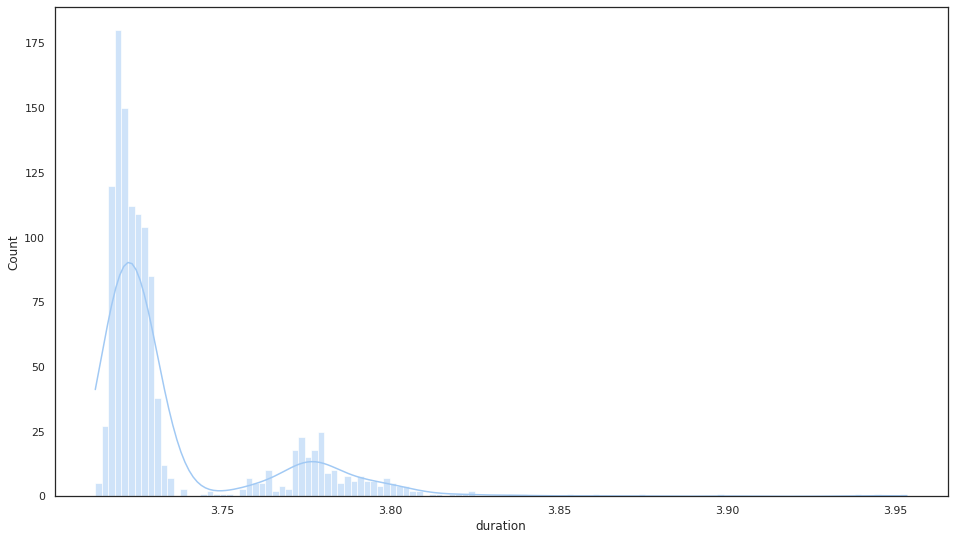

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.histplot(df['duration'], kde=True, ax=ax)
print(f'Mean: {df["duration"].mean():.3f}')
print(f'Standard deviation: {df["duration"].std():.5f}')

## Epoch duration

Epoch duration does not seem to be related to epoch number.

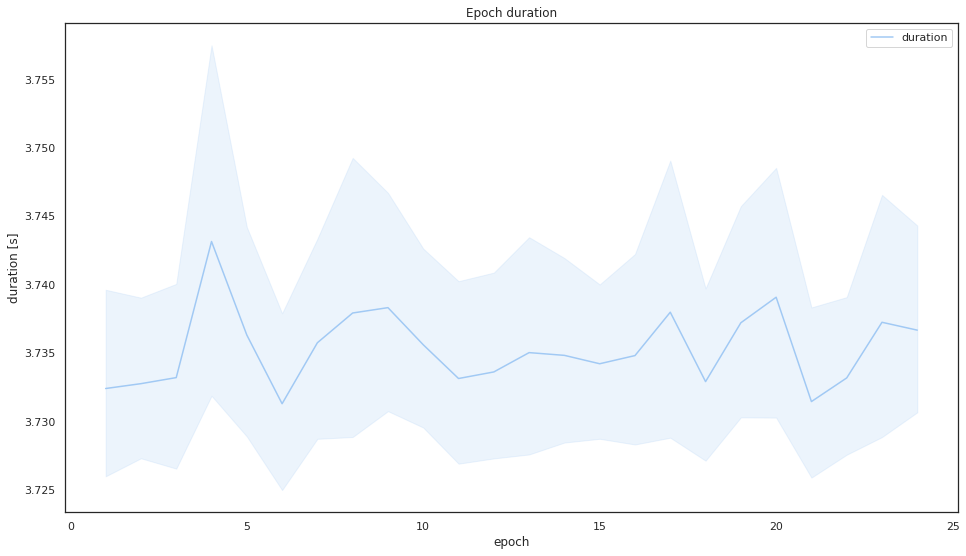

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df.set_index('epoch')[['duration']], ax=ax)
ax.set_ylabel('duration [s]')
ax.set_title('Epoch duration');

## Accuracies over time

The objective of this model is to achieve 94% validation accuracy in the least amount of time. The desired accuracy is reached on most runs.

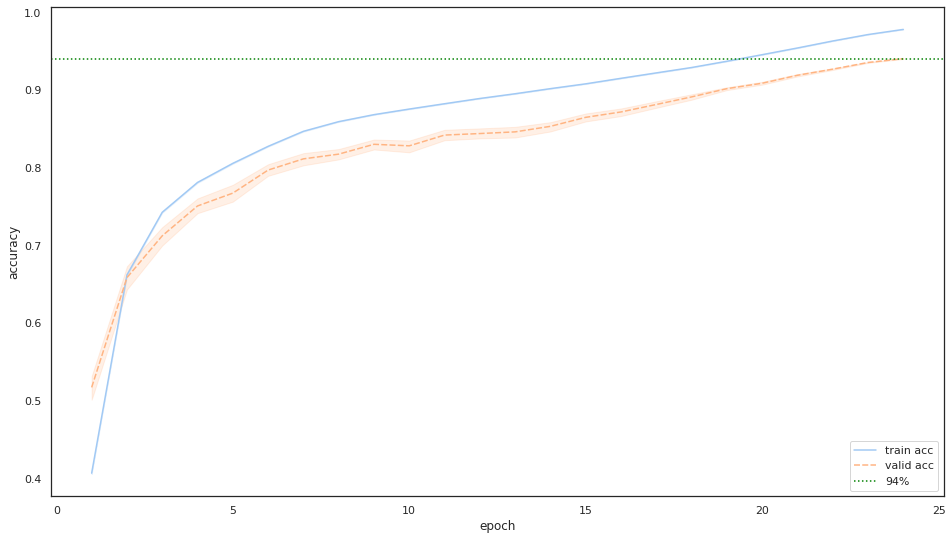

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df.set_index('epoch')[['train acc', 'valid acc']], ax=ax)
ax.axhline(0.94, linestyle=':', color='green', label='94%')
ax.set_ylabel('accuracy')
ax.legend();

## Cumulative energy consumption versus epoch

In [14]:
df_cum_energy_epoch = df.set_index('epoch').groupby(level='epoch').mean().filter(regex='energy').cumsum()

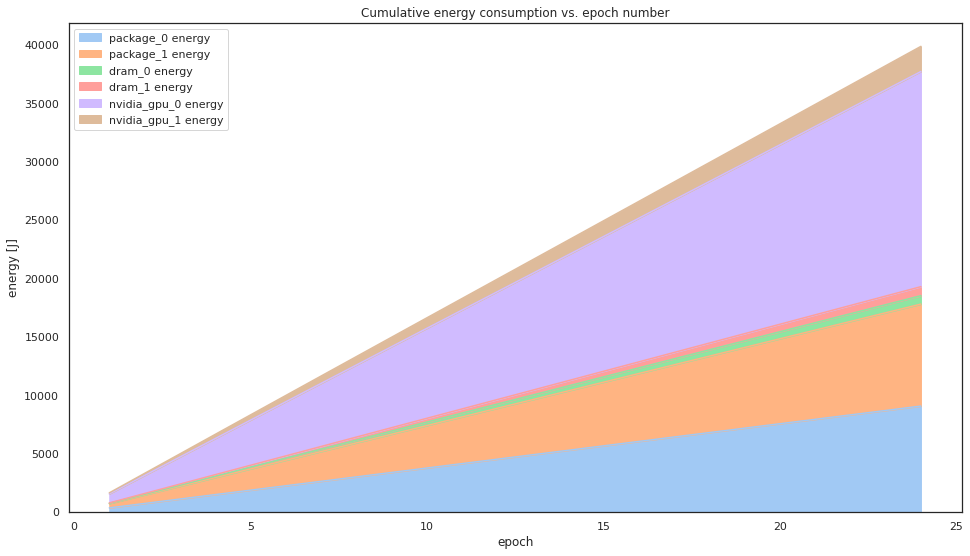

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
df_cum_energy_epoch.plot.area(ax=ax, ylabel='energy [J]', title='Cumulative energy consumption vs. epoch number');

## Cumulative energy consumption versus accuracy

As validation accuracy increases, the energy required for subsequent improvements grows considerably.

In [16]:
df_cum_energy_validacc = df.set_index('epoch').groupby(level='epoch').mean().set_index('valid acc').filter(regex='energy').cumsum()

In [17]:
acc_points = [0.6, 0.7, 0.8, 0.9]

series_cum_energy_validacc = df_cum_energy_validacc.sum(axis=1)
missing_accs = pd.Series({point: np.nan for point in acc_points})
series_cum_energy_validacc_interp = series_cum_energy_validacc.append(missing_accs).sort_index().interpolate(method='index')
energy_points = [series_cum_energy_validacc_interp[point] for point in acc_points]

print(f'Total energy consumed: {series_cum_energy_validacc.iloc[-1]:.2f}')

Total energy consumed: 39886.12


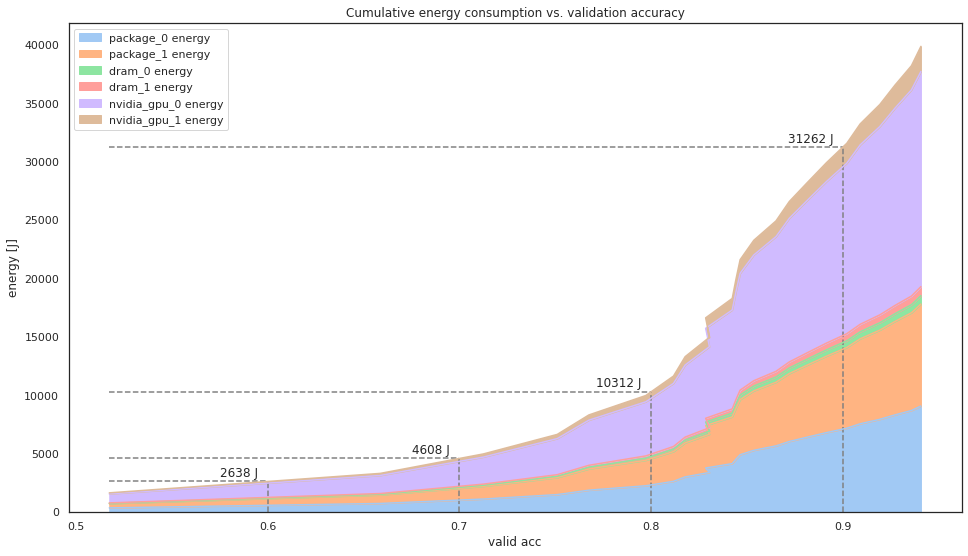

In [18]:
fig, ax = plt.subplots(figsize=(16, 9))
df_cum_energy_validacc.plot.area(ax=ax, ylabel='energy [J]', title='Cumulative energy consumption vs. validation accuracy')

ax.vlines(acc_points, 0, energy_points, color='gray', linestyle="dashed")
ax.hlines(energy_points, df_cum_energy_validacc.index[0], acc_points, color='gray', linestyle="dashed")

for x_point, y_point in zip(acc_points, energy_points):
    ax.text(x_point-0.005, y_point+400, f'{round(y_point)} J', horizontalalignment='right')

In [19]:
for i in range(len(acc_points) - 1):
    print(f'{int(acc_points[i]*100)}% → {int(acc_points[i+1]*100)}%: {round((energy_points[i+1] / energy_points[i] - 1) * 100)}% more energy')

60% → 70%: 75% more energy
70% → 80%: 124% more energy
80% → 90%: 203% more energy


## GPU Power

It appears that power consumption decreases with time.

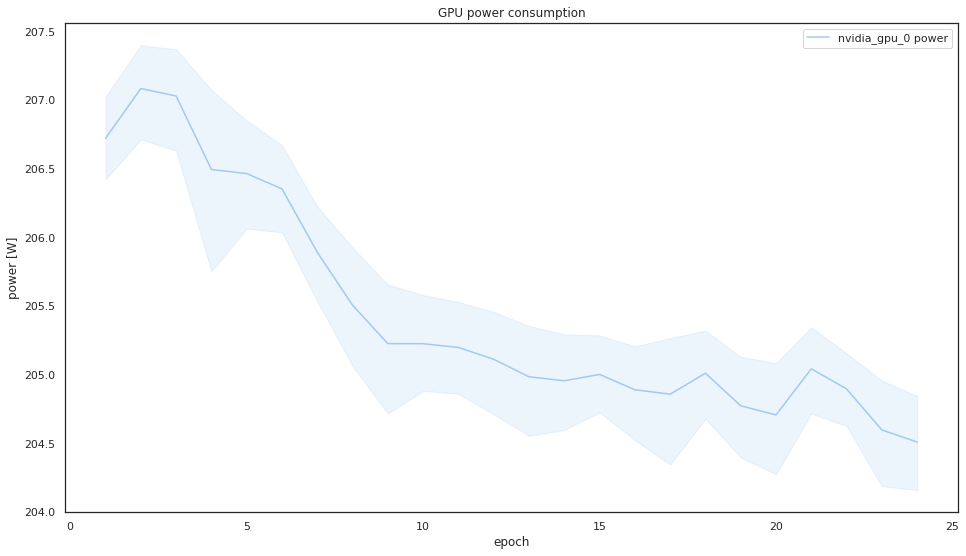

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df.set_index('epoch')[['nvidia_gpu_0 power']], ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('GPU power consumption')
ax.legend();

## Energy versus duration

These graphs compare the energy consumption to the duration of an epoch. The colors represent the epoch number inside its respective run.

It appears that there is no relationship between the epoch number and its duration. However, in the nvidia_0_gpu energy graph there's a clear association between epoch number and energy consumed.

DRAM energy consumption show two additional clusters. The root cause of this is yet to be investigated.

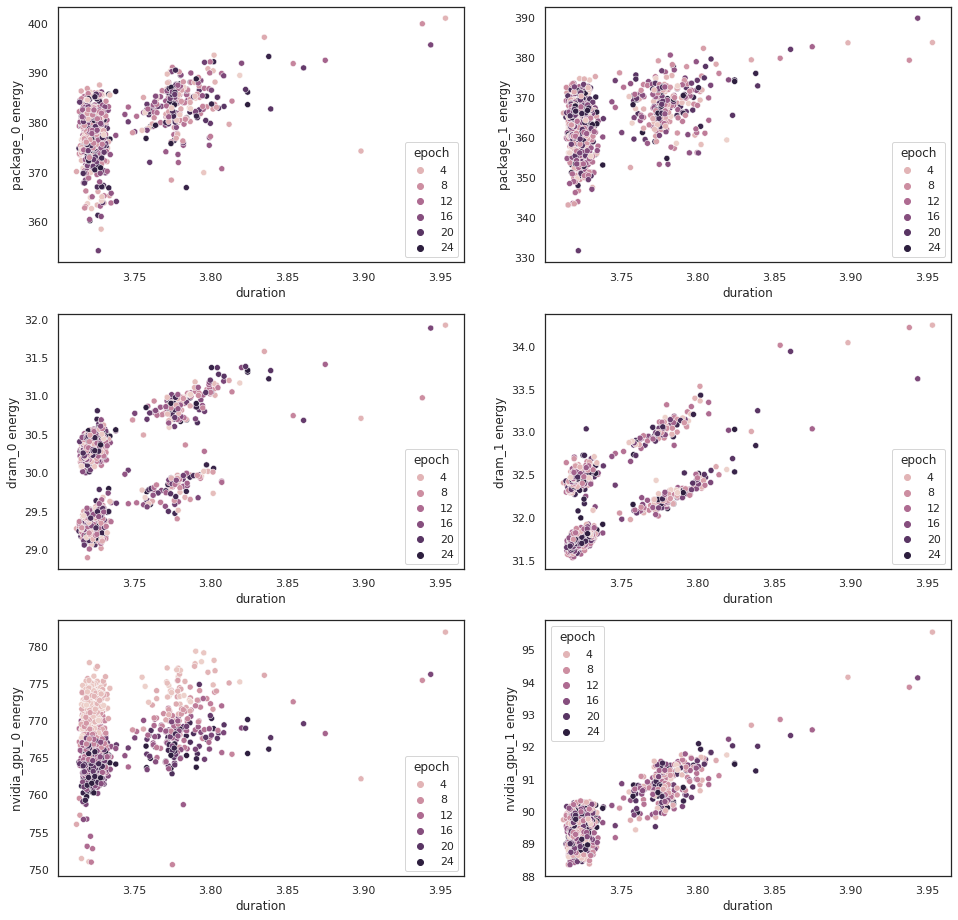

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
sns.scatterplot(data=df, x='duration', y='package_0 energy', ax=axs[0][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='package_1 energy', ax=axs[0][1], hue='epoch')
sns.scatterplot(data=df, x='duration', y='dram_0 energy', ax=axs[1][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='dram_1 energy', ax=axs[1][1], hue='epoch')
sns.scatterplot(data=df, x='duration', y='nvidia_gpu_0 energy', ax=axs[2][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='nvidia_gpu_1 energy', ax=axs[2][1], hue='epoch');

## Power versus duration

It appears that the power does not depend on the duration on all cases but GPU 0. In this case, there appears to be an inverse relationship between epoch power and duration.

The root cause is not clear yet. However, a quick hypothesis is that the GPU requires high power for a fixed amount of time in every epoch and the rest of the time it requires a low energy consumption. Therefore, on longer epochs the average power consumption is lower.

Package, DRAM and GPU 1 power do not seem to be related to duration, possibly because their power consumption is constant throughout the epoch.

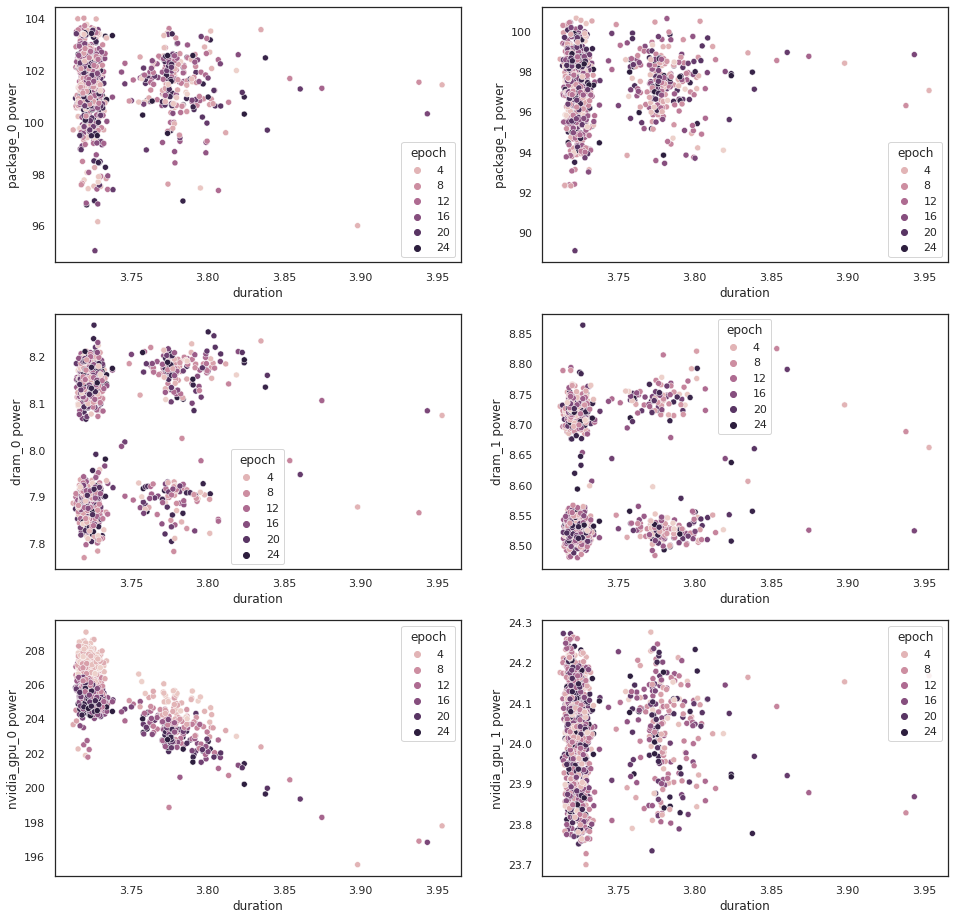

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
sns.scatterplot(data=df, x='duration', y='package_0 power', ax=axs[0][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='package_1 power', ax=axs[0][1], hue='epoch')
sns.scatterplot(data=df, x='duration', y='dram_0 power', ax=axs[1][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='dram_1 power', ax=axs[1][1], hue='epoch')
sns.scatterplot(data=df, x='duration', y='nvidia_gpu_0 power', ax=axs[2][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='nvidia_gpu_1 power', ax=axs[2][1], hue='epoch');

## Energy pair plots

Remarks will be presented in the next graph.

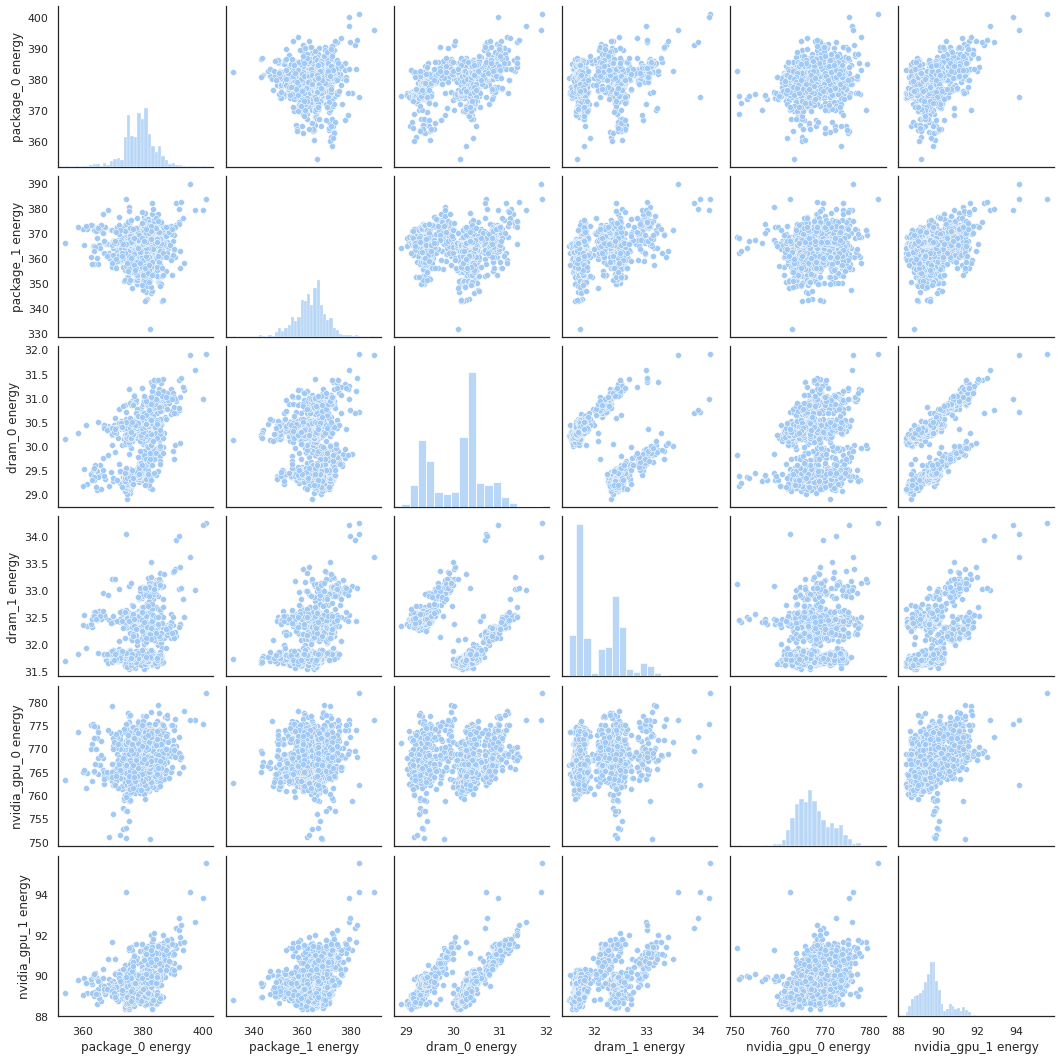

In [23]:
sns.pairplot(df.filter(regex='energy'));

## Power pair plots

As pointed out before, DRAM power consumption is grouped into two clusters. When comparing DRAM 0 to DRAM 1 it is seen that these energy levels are opposite to each other. That is, when DRAM 0 has a low energy consumption, DRAM 1 has a high energy consumption, and vice versa.

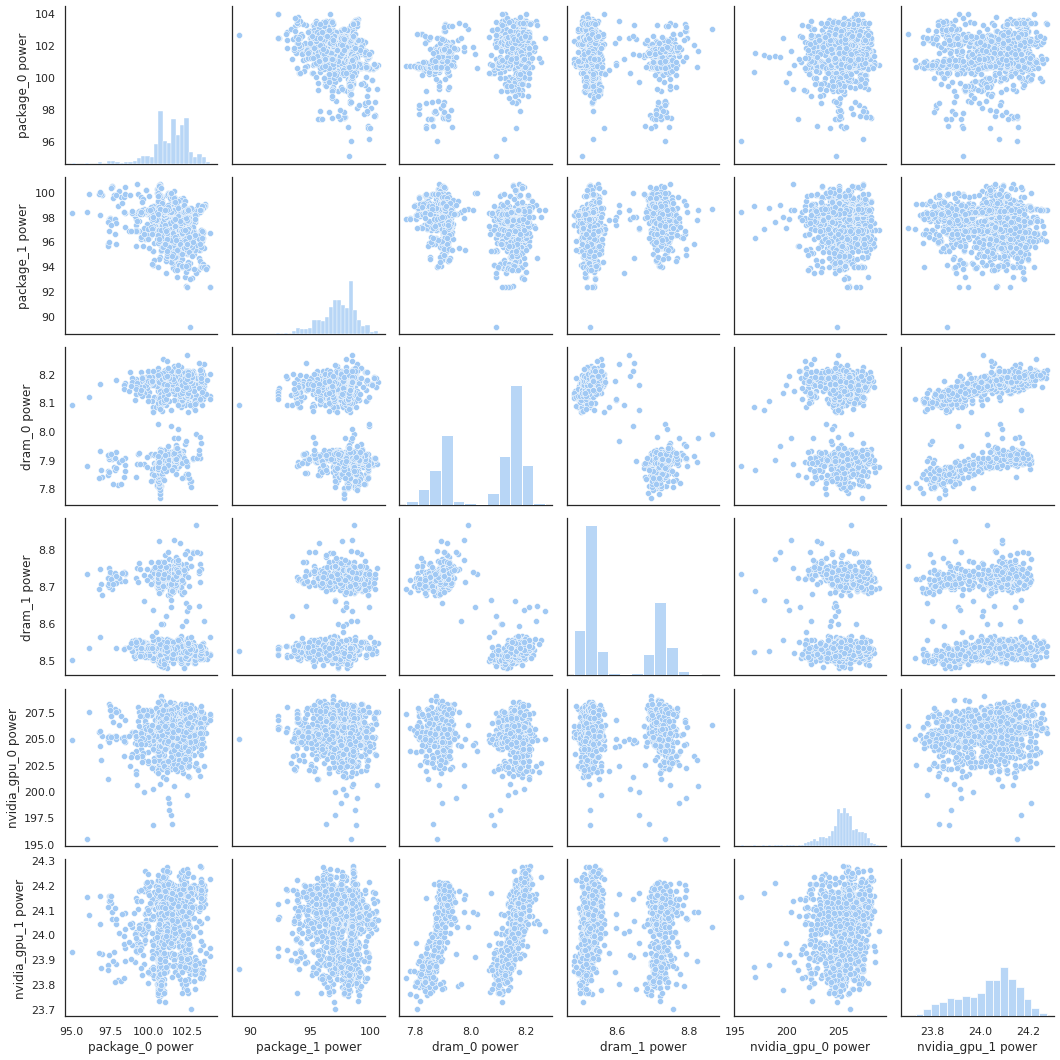

In [24]:
sns.pairplot(df.filter(regex='power'));

## Correlation matrix

The following matrix confirms the previous remarks:

- As epoch number increases, the GPU 0 energy and power consumption decreases.
- As epoch duration increases GPU 0 power consumption decreases.
- Package, DRAM and GPU 1 power do not seem to be related to duration
- There's an inverse correlation between DRAM 0 power and DRAM 1 power. 
- There is no relationship between an epoch's number and its duration.

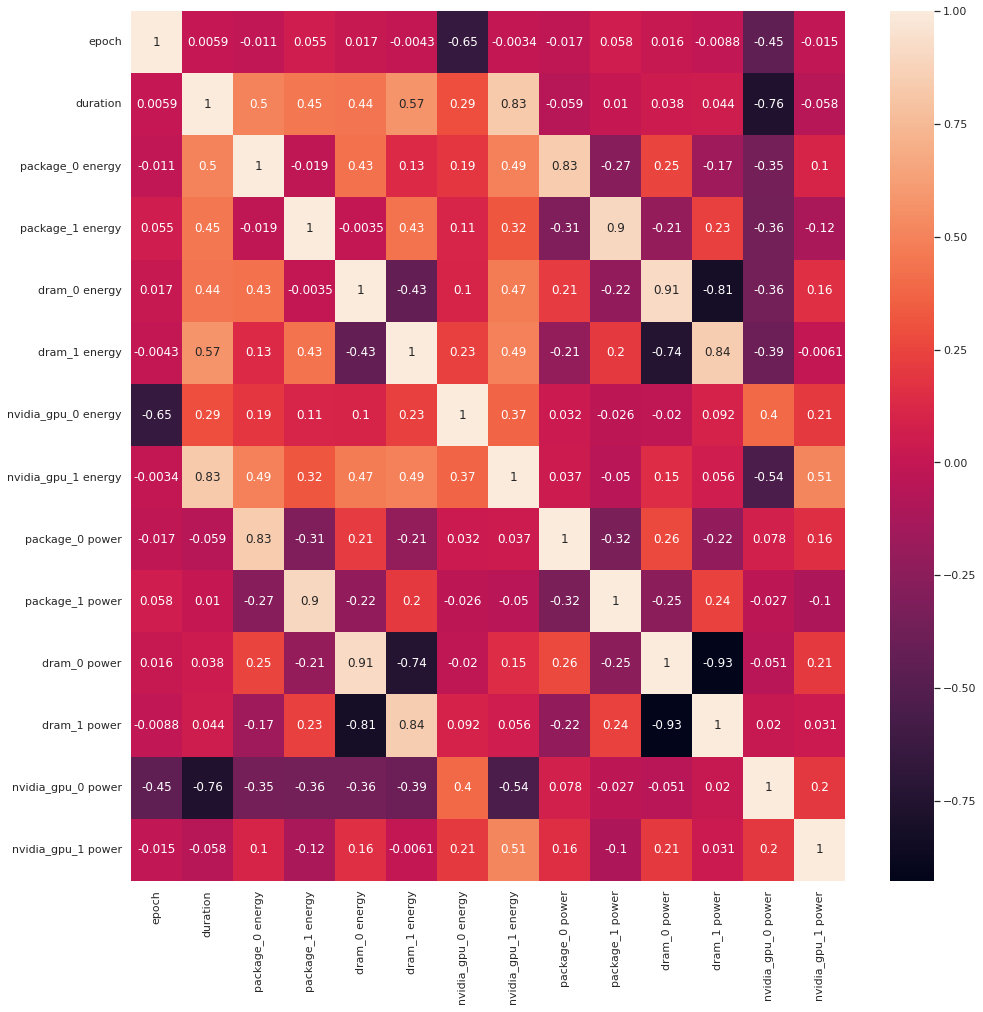

In [25]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    df
    .drop(['train acc'], axis=1)
    .drop(['valid acc'], axis=1)
    .corr(),
    annot=True,
    ax=ax);